# Churn Analysis: Timing of Targeting

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import glob
from sklearn import metrics
import numpy as np
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

# Create Dataset

In [2]:
df_ord_orig = pd.read_csv('../data/order_churn_data.csv')
df_cus_orig = pd.read_csv('../data/churn_dataset.csv')

In [3]:
# limit dataset to customers who came after 2017
cust_ids = df_cus_orig.loc[(df_cus_orig.first_order_created_datetime >= "2017-01-01")
                          & (df_cus_orig.last_order_created_datetime <= "2018-09-30")].customer_db_id
print(len(cust_ids), '/',  len(df_cus_orig))

33304 / 68891


In [4]:
df_ord = df_ord_orig.loc[df_ord_orig.customer_db_id.isin(cust_ids)]
df_cus = df_cus_orig.loc[df_cus_orig.customer_db_id.isin(cust_ids)]
df_ord = df_ord.merge(df_cus[['customer_db_id', 'customer_id', 'completed_orders', 'last_order_created_datetime']], 
                      on=['customer_db_id', 'customer_id'], how='inner')

In [5]:
df_items = pd.read_csv('../data/input/items.csv')
df_prods = df_items.groupby(['order_id']).agg({'quantity': 'sum', 'product_id': 'nunique'}).reset_index()
df_prods = df_prods.rename(columns={'product_id': 'num_products'})
df_ord = df_ord.merge(df_prods, on=['order_id'], how='left')

In [6]:
df_items = df_items.groupby(['order_id', 'product_group'])['quantity'].sum().reset_index()
df_items = df_items.pivot_table(index='order_id', columns='product_group', values='quantity', fill_value=0)
df_items.columns = ['prod_' + c for c in df_items.columns]
df_ord = df_ord.merge(df_items, on=['order_id'], how='left')

In [7]:
df_braze = pd.read_csv('../data/braze_customers.csv')
df_braze = df_braze[['customer_id', 'email_subscribe', 'push_subscribe']]
df_braze.email_subscribe = df_braze.email_subscribe.isin(['subscribed', 'opted_in'])
df_braze.push_subscribe = df_braze.push_subscribe.isin(['subscribed', 'opted_in'])

df_ord = df_ord.merge(df_braze, on='customer_id', how='left')
df_ord.email_subscribe = df_ord.email_subscribe.fillna(False)
df_ord.push_subscribe = df_ord.push_subscribe.fillna(False)

In [8]:
df_ord = df_ord.drop(['cluster', 'cluster_name'], axis=1)
df_clusters = pd.read_csv('../data/clustering/item_clusters_cities.csv')
df_ord = df_ord.merge(df_clusters, on='order_id', how='left')

In [9]:
df_ord['days_since_last_seen'] = (datetime(2018,9,30) - pd.to_datetime(df_ord.last_order_created_datetime)).dt.days
df_ord.order_created_datetime = pd.to_datetime(df_ord.order_created_datetime)
df_ord['order_day'] = (df_ord.order_created_datetime - datetime(2017, 1, 1)).dt.days
df_ord['order_weekday'] = (df_ord.order_created_datetime).dt.weekday
df_ord['order_month'] = (df_ord.order_created_datetime).dt.month

In [10]:
df_ord = df_ord.drop_duplicates()

In [11]:
last_day = (datetime(2018,9,30) - datetime(2017,1,1)).days
last_day

637

### Completed Dataset

In [12]:
# only completed orders
df_comp = df_ord.loc[(df_ord.order_state == "completed") & (df_ord.completed_orders > 0)]
df_comp = df_comp.sort_values(['customer_db_id', 'order_created_datetime'])
df_comp['order_created_datetime'] = pd.to_datetime(df_comp.order_created_datetime)

# completed orders
df_comp['completed_orders'] = df_comp.groupby(['customer_db_id']).transform('count')
df_comp['order_comp_num'] = df_comp.groupby(['customer_db_id']).cumcount()
df_comp['next_order_date'] = df_comp.groupby('customer_db_id')['order_created_datetime'].shift(-1)
df_comp['last_order_date'] = df_comp.groupby('customer_db_id')['order_created_datetime'].shift(1)
df_comp['days_until_next_comp'] = (df_comp.next_order_date - df_comp.order_created_datetime).dt.days
df_comp['days_since_last_comp'] = (df_comp.order_created_datetime - df_comp.last_order_date).dt.days
df_comp['weeks_until_next_comp'] = df_comp.days_until_next_comp // 7

df_comp = df_comp.drop(['next_order_date', 'last_order_date'], axis=1)

In [13]:
df_comp['first_completed_order'] = df_comp.groupby(['customer_db_id'])['order_created_datetime'].transform('min')
df_comp['last_completed_order'] = df_comp.groupby(['customer_db_id'])['order_created_datetime'].transform('max')
df_comp['lifetime'] = (df_comp.last_completed_order - df_comp.first_completed_order).dt.days
df_comp['first_completed_order_day'] = (df_comp.first_completed_order - datetime(2017, 1, 1)).dt.days
df_comp['last_completed_order_day'] = (df_comp.last_completed_order - datetime(2017, 1, 1)).dt.days
df_comp['order_day'] = (df_comp.order_created_datetime - datetime(2017, 1, 1)).dt.days

# Customer Lifetime
Created dataframe for customer lifetime

In [14]:
df_life = df_comp.copy()
df_life = df_life.sort_values(['customer_id', 'order_day'])

df_life['first_order'] = df_life.order_comp_num == 0
df_life['last_order'] = df_life.order_comp_num == (df_life.completed_orders - 1)
df_life['returned'] = ~df_life.last_order

df_life['frequency'] = df_life.groupby('customer_id')['days_since_last_comp'].transform(lambda x: x.expanding().mean())
df_life['order_day_expected'] = df_life.order_day + df_life.frequency
df_life.order_day_expected = df_life.groupby('customer_id').order_day_expected.shift().fillna(df_life.order_day)
df_life['order_expected_diff'] = df_life.order_day - df_life.order_day_expected

df_life['churn_factor'] = df_life.days_until_next_comp / df_life.frequency
df_life.loc[df_life.last_order, 'churn_factor'] = df_life.days_since_last_seen / df_life.frequency

df_life['order_day_expected_45'] = df_life.order_day + 45 + 8
df_life.order_day_expected_45 = df_life.groupby('customer_id').order_day_expected_45.shift().fillna(df_life.order_day)
df_life['order_expected_45_diff'] = df_life.order_day - df_life.order_day_expected_45

df_life['churned_after'] = df_life.days_until_next_comp > (45 + 8)
df_life.loc[df_life.last_order, 'churned_after'] = df_life.days_since_last_seen > (45 + 8)
df_life['churned_before'] = df_life.groupby('customer_id').churned_after.shift().fillna(False)
df_life.loc[df_life.churned_after, 'entered_inactive'] = df_life.order_day + 45 + 8

df_life['revenue_voucher'] = df_life.revenue + df_life.voucher_value
df_life.loc[~(df_life.voucher_value > 0), 'voucher_channel'] = 'no_voucher'
df_life['voucher_ratio'] = (df_life.voucher_value / df_life.revenue_voucher).round(1)

df_life['returned_CRM'] = df_life.final_click_channel.str.contains('crm')
df_life['returned_CRM'] = df_life.groupby('customer_id').returned_CRM.shift(-1).fillna(False)
df_life['returned_voucher'] = df_life.groupby('customer_id').voucher_value.shift(-1).fillna(0)
df_life['returned_voucher'] = (df_life.returned_voucher > 0)
df_life['over_frequency'] = df_life.churn_factor >= 1
df_life['freq_median'] = df_life.groupby('order_day')['frequency'].transform('median')

In [15]:
df_life.voucher_channel = df_life.voucher_channel.fillna('unknown')

### Sample Customer

In [16]:
def plot_customer_lifetime(sample_customer):
    df_life_sample = df_life.loc[df_life.customer_id == sample_customer]
    
    fig, ax = plt.subplots(figsize=(10,5))
    # plot vouchers
    sns.scatterplot(data=df_life_sample.loc[df_life_sample.voucher_value > 0], 
                    x='order_day', y='voucher_value', marker='x', color='black', label='voucher_value')
    
    # plot journey and expected journy
    sns.lineplot(data=df_life_sample, x='order_day', y='revenue_voucher', 
                 marker='o', label='order revenue', color='green')
    sns.lineplot(data=df_life_sample, x='order_day_expected', y='revenue_voucher', 
                 marker='o', label='expected_order', color='gray', alpha=0.3)
    
    # plot final click channel
    sns.scatterplot(data=df_life_sample.loc[df_life_sample.final_click_channel.str.contains('crm')],
                   x='order_day', y='revenue_voucher', color='red', label='crm_click', zorder=10)
    
    # plot entering inactive segment
    sns.rugplot(df_life_sample.entered_inactive, color='black', height=1, linestyle='--', label='inactive')
    

    plt.xticks(rotation=70)
    plt.ylim(0)
    plt.title(sample_customer)
    plt.legend()
    plt.show()

In [17]:
samples = df_ord.loc[(df_ord.days_until_next_order > 50) & (df_ord.completed_orders > 3) & (df_ord.order_num == 2)]['customer_id'].sample(3)
samples

79039    CUS-Y0696596
48580    CUS-E4298312
26399    CUS-P2092598
Name: customer_id, dtype: object

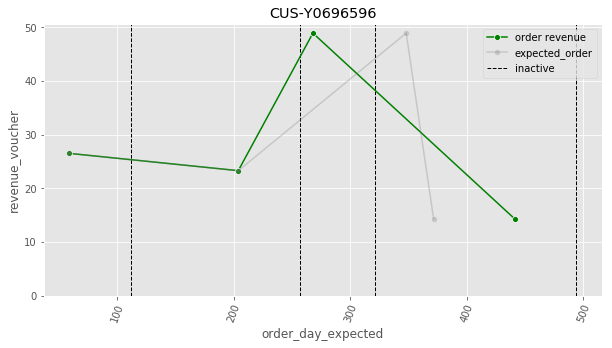

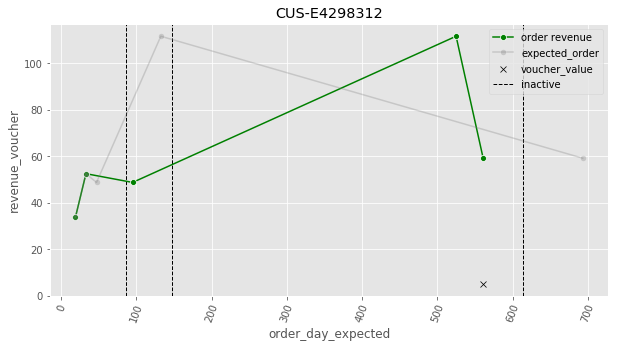

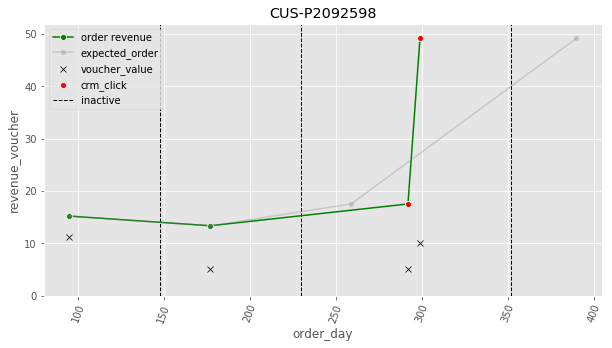

In [18]:
for s in samples:
    plot_customer_lifetime(s)

# Active Customers
- How does timing of churn impact if customers return

### Prediction: IOF

count    40514.000000
mean         2.658542
std         49.974405
min       -560.000000
25%         -8.000000
50%          0.000000
75%          9.300000
max        560.000000
Name: order_expected_diff, dtype: float64

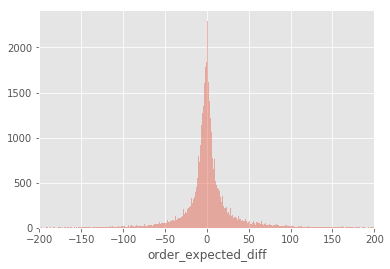

In [19]:
a = df_life.loc[df_life.order_comp_num > 1]
sns.distplot(a.order_expected_diff, bins=1000, kde=False)
plt.xlim(-200,200)
a.order_expected_diff.describe()

In [20]:
metrics.mean_absolute_error(a.order_day, a.order_day_expected)

23.594522853990572

### Prediction: 45 Days

In [21]:
metrics.mean_absolute_error(a.order_day, a.order_day_expected_45)

37.119069951128004

count    40514.000000
mean       -17.771437
std         45.514431
min        -53.000000
25%        -41.000000
50%        -32.000000
75%        -13.000000
max        542.000000
Name: order_expected_45_diff, dtype: float64

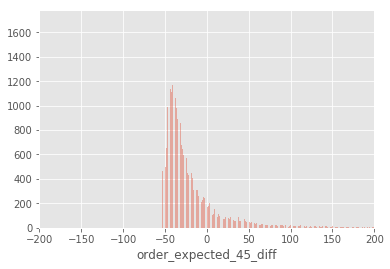

In [22]:
sns.distplot(a.order_expected_45_diff, bins=1000, kde=False)
plt.xlim(-200,200)
a.order_expected_45_diff.describe()

## Group customers based on frequency
- good timing: if frequency 53 (45+8) days +/- 7 days
- soon: if frequency > 53+7
- late: if frequency < 53-7

In [23]:
df_life_2 = df_life.loc[df_life.order_comp_num > 1]
df_life_2['target_timing'] = ['soon' if x >= 53+7 else 'late' if x <= 53-7 else 'correct' for x in df_life_2.frequency]

In [24]:
stats = df_life_2.loc[df_life_2.churned_after].groupby(['target_timing', 'returned'])['order_id'].nunique().reset_index()
stats['target_total'] = stats.groupby('target_timing')['order_id'].transform('sum')
stats['order_perc'] = stats.order_id / stats.target_total

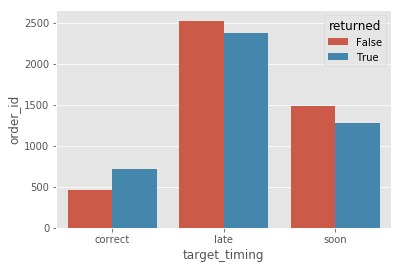

In [25]:
sns.categorical.barplot(data=stats, x='target_timing', y='order_id', hue='returned')

# New Customers
Hypothesis: If we can target new customers at better timings, we are gonna see less churn.

In [26]:
df_life0 = df_life.loc[(df_life.order_comp_num == 0) & ~df_life.last_order]
df_life0_v = df_life0.loc[df_life0.returned_voucher]
df_life0_nv = df_life0.loc[~df_life0.returned_voucher]
df_life1 = df_life.loc[(df_life.order_comp_num > 0) & ~df_life.last_order]

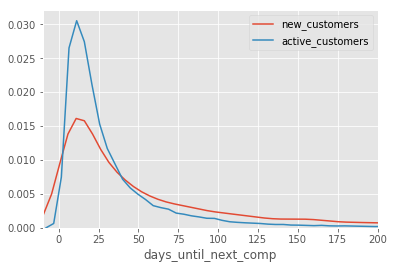

In [27]:
sns.distplot(df_life0.days_until_next_comp, norm_hist=True, hist=False, label='new_customers')
sns.distplot(df_life1.days_until_next_comp, norm_hist=True, hist=False, label='active_customers')
plt.xlim(-10,200)
plt.legend()
plt.show()

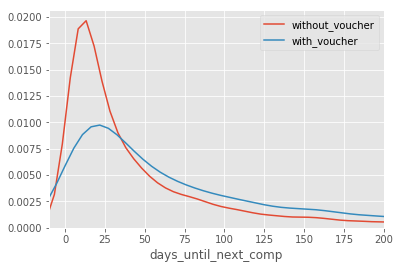

In [28]:
sns.distplot(df_life0_nv.days_until_next_comp, norm_hist=True, hist=False, label='without_voucher')
sns.distplot(df_life0_v.days_until_next_comp, norm_hist=True, hist=False, label='with_voucher')
plt.xlim(-10,200)
plt.legend()

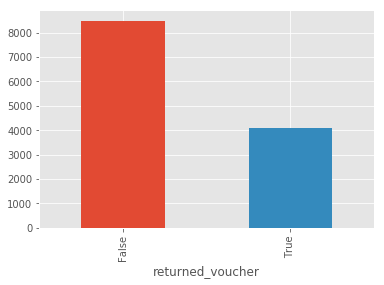

In [29]:
df_life0.groupby('returned_voucher')['customer_db_id'].nunique().plot(kind='bar')

# Remove Outliers
- remove people who came back through voucher
- limit to 90 days

In [30]:
df_life0_out = df_life0.loc[(df_life0.days_until_next_comp <= 90) & ~(df_life0.returned_voucher) & ~(df_life0.corporate)]
df_life1_out = df_life1.loc[(df_life1.days_until_next_comp <= 90) & ~(df_life1.corporate)]

New customers who don't return with vouchers, have similar behaviour to returning customers.

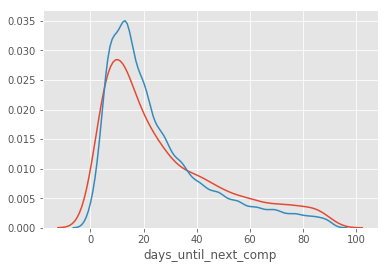

In [31]:
sns.distplot(df_life0_out.days_until_next_comp, norm_hist=True, hist=False)
sns.distplot(df_life1_out.days_until_next_comp, norm_hist=True, hist=False)

In [32]:
df_life0_out.days_until_next_comp.describe()

count    6495.000000
mean       27.477290
std        22.365901
min         0.000000
25%        10.000000
50%        20.000000
75%        40.000000
max        90.000000
Name: days_until_next_comp, dtype: float64

In [33]:
df_life0_out['customer_type'] = 0
df_life1_out['customer_type'] = 1
df_life_out = df_life0_out.append(df_life1_out)

# Baseline New Customers

In [34]:
def rmse(y_true, y_pred):
    return np.sqrt(metrics.mean_squared_error(y_true, y_pred))

In [35]:
df_error = pd.DataFrame(index=range(1,60), columns=['mae', 'rmse'], dtype=np.int)
for days_threshold in range(1,60):
    mae = metrics.mean_absolute_error(df_life0_out.days_until_next_comp, np.ones(len(df_life0_out)) * days_threshold)
    df_error.loc[days_threshold, 'mae'] = mae
    mse = metrics.mean_squared_error(df_life0_out.days_until_next_comp, np.ones(len(df_life0_out)) * days_threshold)
    df_error.loc[days_threshold, 'rmse'] = np.sqrt(mse)

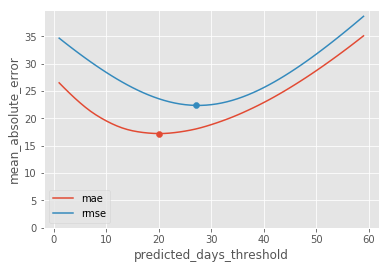

In [36]:
df_error['mae'].plot(label='mae')
df_error['rmse'].plot(label='rmse')
plt.scatter(df_error.mae.argmin(), df_error.mae.min())
plt.scatter(df_error.rmse.argmin(), df_error.rmse.min())
plt.xlabel('predicted_days_threshold')
plt.ylabel('mean_absolute_error')
plt.ylim(0)
plt.legend()
plt.show()

In [37]:
df_error.min()

mae     17.222633
rmse    22.369271
dtype: float64

Text(0.5,0,'Error Distribution')

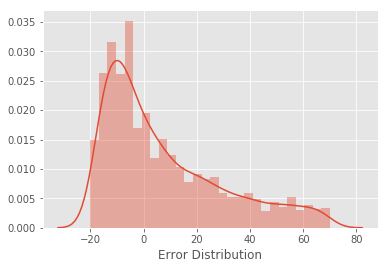

In [38]:
sns.distplot((df_life0_out.order_day + df_life0_out.days_until_next_comp) - (df_life0_out.order_day + 20))
plt.xlabel('Error Distribution')

# Baseline All Customers

In [39]:
df_error = pd.DataFrame(index=range(1,60), columns=['new', 'active', 'all'], dtype=np.int)

for days_threshold in range(1,60):
    err_all = rmse(df_life_out.days_until_next_comp, np.ones(len(df_life_out)) * days_threshold)
    df_error.loc[days_threshold, 'all'] = err_all
    err_new = rmse(df_life0_out.days_until_next_comp, np.ones(len(df_life0_out)) * days_threshold)
    df_error.loc[days_threshold, 'new'] = err_new
    err_act = rmse(df_life1_out.days_until_next_comp, np.ones(len(df_life1_out)) * days_threshold)
    df_error.loc[days_threshold, 'active'] = err_act

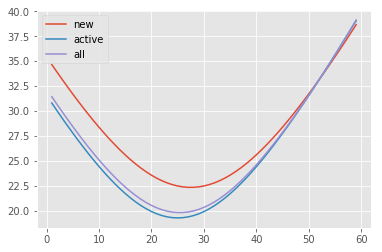

In [40]:
df_error.plot()

In [41]:
df_error.min()

new       22.369271
active    19.306490
all       19.840830
dtype: float64

# Create Features

In [42]:
def create_feature(df, groupby_col, agg_col, transformation, new_col_name):
    df[new_col_name] = df.groupby(groupby_col)[agg_col].transform(transformation).fillna(0).round()
    return df

In [43]:
transforms = ['mean', 'std', 'median']

for t in transforms:
    df_life_out = create_feature(df_life_out, 'cluster', 'days_until_next_comp', t, 'cluster_freq_' + t)
    df_life_out = create_feature(df_life_out, 'order_month', 'days_until_next_comp', t, 'month_freq_' + t)
    df_life_out = create_feature(df_life_out, 'city', 'days_until_next_comp', t, 'city_freq_' +t)
    df_life_out = create_feature(df_life_out, 'quantity', 'days_until_next_comp', t, 'quantity_freq_'+ t)

In [44]:
df_life_out['service_class_paid'] = [True if x in ['PLUS', 'EXPRESS'] else False for x in df_life_out.service_class]
df_life_out['revenue_per_prod'] = (df_life_out.revenue / df_life_out.quantity).round()
# df_life_out['order_attempt_before'] = df_life_out.order_comp_num != df_life_out.order_num

# Predict days
- Find a model that predicts better than 18 days MAE

In [186]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_regression, mutual_info_regression, mutual_info_classif
from sklearn.neural_network import MLPRegressor, MLPClassifier

In [46]:
# features to predict
feats = [# aggregate features
         'cluster_freq_mean', 'cluster_freq_std', 'cluster_freq_median',
         'month_freq_mean', 'month_freq_std', 'month_freq_median',
         'month_rev_mean', 'month_rev_median',
         'city_freq_mean', 'city_freq_std', 'city_freq_median',
         'quantity_freq_mean', 'quantity_freq_std', 'quantity_freq_median',
         # order features
         'service_class_paid', 'revenue_per_prod', #'order_attempt_before', 'order_num',
         'city', 'revenue', 'voucher_ratio', 'gender', 'num_products', 
         'order_x', 'order_y', 'email_subscribe', 'corporate',
         'quantity', 'service_class', 'software_type', 'voucher_used', 'final_click_channel', 
         'order_month']
feats = ['service_class_paid', 'revenue_per_prod', 'num_products', 'quantity', 'gender', 'voucher_used',
         'city', 'revenue', 'voucher_ratio', 'corporate', 'software_type', 'order_month', 'customer_type']
feats += [c for c in df_life0_out.columns if 'prod_' in c]
pred_name = ['days_until_next_comp']

In [47]:
df_pred = df_life_out[feats + pred_name]
df_pred.shape

(41468, 33)

### Encode string columns

In [48]:
str_cols = df_pred.select_dtypes(['object']).columns.tolist()
for col in str_cols:
    df_pred = df_pred.merge(pd.get_dummies(df_pred[col], prefix=col), left_index=True, right_index=True)
    df_pred = df_pred.drop(col, axis=1)

In [49]:
df_pred.shape

(41468, 39)

### Round Numerical Columns


In [50]:
round_cols = ['revenue', 'freq_median']
for col in round_cols:
    try:
        df_pred[col] = df_pred[col].round()
    except:
        pass

### Fill NANs

In [51]:
nans = df_pred.isnull().sum()
nans = nans[nans > 0].sort_values(ascending=False)
nans

prod_WashFold        1
prod_Underwear       1
num_products         1
quantity             1
prod_Accessories     1
prod_Blazer          1
prod_Blouse          1
prod_Coats           1
prod_Dress           1
prod_DressSpecial    1
prod_Household       1
prod_Knitwear        1
prod_Others          1
prod_Shirt           1
prod_Shorts          1
prod_Skirt           1
prod_Skiwear         1
prod_Suit            1
prod_Top             1
prod_Trousers        1
prod_Tshirt          1
revenue_per_prod     1
dtype: int64

In [52]:
# df_pred = df_pred.dropna(subset=['order_x', 'order_y'], axis=0)

In [53]:
df_pred = df_pred.fillna(0)

In [54]:
df_pred.head()

,service_class_paid,revenue_per_prod,num_products,quantity,voucher_used,revenue,voucher_ratio,corporate,order_month,customer_type,...,days_until_next_comp,gender_female,gender_male,city_Berlin,city_London,city_Paris,software_type_Android,software_type_Desktop Web,software_type_Mobile Web,software_type_iOS
53773,True,3.892467,6.0,21.0,False,82.0,0.1,False,7,0,...,7.0,1,0,0,1,0,0,0,0,1
23734,True,9.373958,2.0,8.0,False,75.0,0.0,False,8,0,...,26.0,1,0,0,0,1,0,0,0,1
81161,True,5.769969,8.0,15.0,False,87.0,0.0,False,12,0,...,59.0,0,1,0,1,0,0,0,0,1
25594,True,6.353472,2.0,12.0,True,76.0,0.1,False,3,0,...,19.0,0,1,0,0,1,0,0,0,1
68602,False,1.871677,1.0,12.0,False,22.0,0.0,False,7,0,...,15.0,0,1,0,1,0,0,0,0,1


# Train / Test Set

In [55]:
test_size=0.1

In [56]:
X = df_pred.drop(pred_name, axis=1).values
y = df_pred[pred_name].values

# Find Outlier Data Points

In [57]:
from sklearn.ensemble import IsolationForest

iso_frst = IsolationForest()
X_is_outlier = iso_frst.fit_predict(X)

In [58]:
pd.Series(X_is_outlier).value_counts()

 1    37321
-1     4147
dtype: int64

In [59]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_pca.shape

(41468, 2)

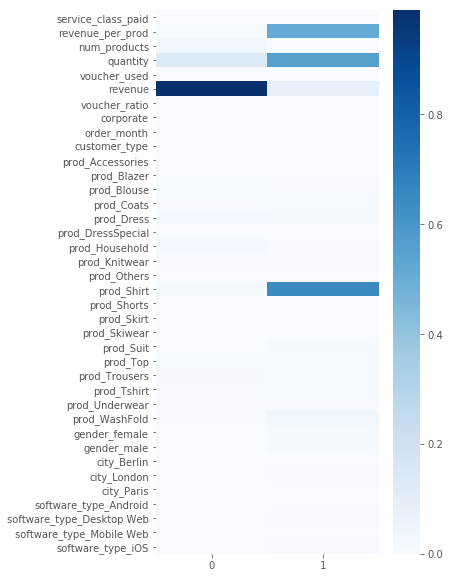

In [60]:
plt.figure(figsize=(5,10))
sns.heatmap(abs(pca.components_).T, yticklabels=df_pred.drop(pred_name, 1).columns, cmap='Blues')

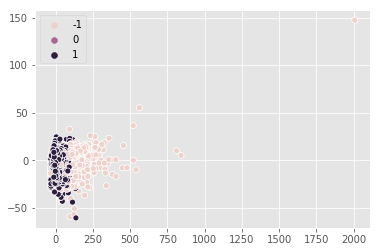

In [61]:
sns.scatterplot(X_pca[:, 0], X_pca[:, 1], hue=X_is_outlier)

In [62]:
X = X[X_is_outlier > 0]
y = y[X_is_outlier > 0]
X_norm = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
X_train.shape, X_test.shape

((33588, 38), (3733, 38))

In [63]:
df_pred = df_pred.iloc[X_is_outlier > 0]

# PCA

In [64]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)
X_pca_norm = StandardScaler().fit_transform(X_pca)

X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca_norm, y, test_size=test_size, random_state=42)
X_pca_train.shape, X_pca_test.shape

((33588, 3), (3733, 3))

# Feature Importance

In [65]:
sk = SelectPercentile(mutual_info_regression, percentile=20).fit(X, y)
df_sk = pd.DataFrame()
df_sk['feature'] = df_pred.drop(pred_name, 1).columns
df_sk['scores'] = sk.scores_

In [66]:
df_sk.sort_values('scores', ascending=False).head(10)

,feature,scores
19,prod_Shirt,0.051009
1,revenue_per_prod,0.050165
3,quantity,0.036912
28,prod_WashFold,0.017859
32,city_London,0.014391
8,order_month,0.014146
23,prod_Suit,0.012024
26,prod_Tshirt,0.009588
5,revenue,0.009548
31,city_Berlin,0.007441


# Features Different For New / Active Customers

In [208]:
# similarity
df_sim = df_pred.loc[df_pred.customer_type == 1].sort_values(['days_until_next_comp'])
df_sim['days_group'] = pd.qcut(df_sim.days_until_next_comp, q=10, labels=False)
# sim = metrics.pairwise.cosine_similarity(df_sim.drop(['days_until_next_comp', 'days_group'], 1).loc[df_pred.customer_type == 1],
#                                          df_sim.drop(['days_until_next_comp', 'days_group'], 1).loc[df_pred.customer_type == 1])

In [209]:
df_sim.columns[29]

'days_until_next_comp'

In [210]:
X_sim = MinMaxScaler().fit_transform(df_sim.values)
# X_sim = df_sim.values.astype(int)

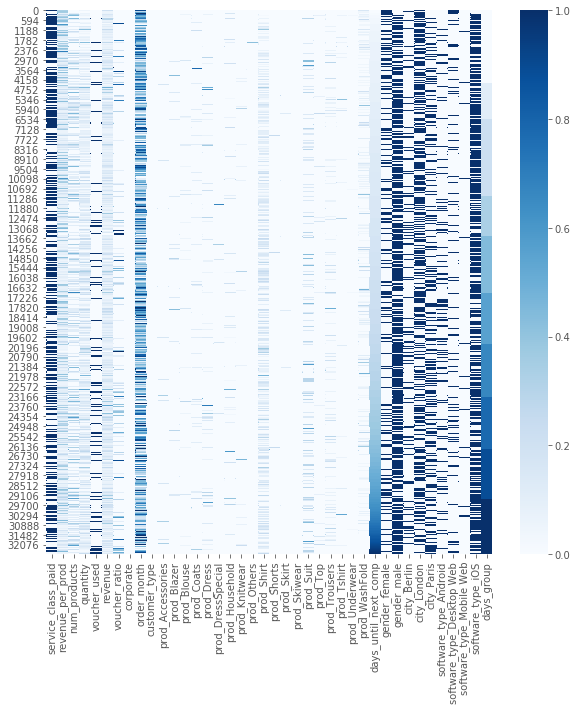

In [211]:
plt.figure(figsize=(10,10))
sns.heatmap(X_sim, xticklabels=df_sim.columns, cmap='Blues')

In [131]:
sim.shape

(855, 855)

In [136]:
km = KMeans(n_clusters=10)
km.fit(sim)
km.labels_.shape

(864,)

In [115]:
s = sim[0:2]
s = s.argsort()[-10:]
df_pred.iloc[s[0]].days_until_next_comp.std()

19.448302627410403

In [112]:
df_pred.loc[df_pred.customer_type == 1].days_until_next_comp.std()

19.05496319788576

In [67]:
# sk = SelectPercentile(mutual_info_classif, percentile=20).fit(df_pred.drop('customer_type', 1), df_pred.customer_type)
# df_sk = pd.DataFrame()
# df_sk['feature'] = df_pred.drop('customer_type', 1).columns
# df_sk['scores'] = sk.scores_

In [68]:
# df_sk.sort_values('scores', ascending=False).head(10)

In [69]:
# # sns.categorical.boxplot(df_pred.customer_type, df_pred.revenue_per_prod)
# sns.categorical.violinplot(df_pred.customer_type, df_pred.revenue_per_prod)

# Select Features

In [70]:
selected_feats = df_sk.sort_values('scores', ascending=False)[:20].feature.tolist()

In [71]:
# features from feature selection
X_feat = df_pred[selected_feats].values
y_feat = df_pred[pred_name]
X_feat_norm = StandardScaler().fit_transform(X_feat)

X_feat_train, X_feat_test, y_feat_train, y_feat_test = train_test_split(X_feat_norm, y, test_size=test_size, random_state=42)
X_feat_train.shape, X_feat_test.shape

((33588, 20), (3733, 20))

In [72]:
# polynomial features
poly = PolynomialFeatures(2, interaction_only=True)
X_poly = poly.fit_transform(X_feat)
X_poly_norm = StandardScaler().fit_transform(X_poly)

X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(X_poly_norm, y, test_size=test_size, random_state=42)
X_poly_train.shape, X_poly_test.shape

((33588, 211), (3733, 211))

# Linear Regression

In [73]:
def cross_validation(model, X, y, splits=4):
    kf = KFold(n_splits=splits)
    error = []
    
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val).clip(y.min(), y.max())
        rmse = np.sqrt(metrics.mean_squared_error(y_val, y_pred))
        error.append(rmse)
        
    return np.array(error)

In [74]:
# all features without outliers
lin_reg = linear_model.LinearRegression()
cross_validation(lin_reg, X_train, y_train).mean()

18.639215359998545

In [75]:
# best 20 correlated features
lin_reg_feat = linear_model.LinearRegression()
cross_validation(lin_reg_feat, X_feat_train, y_feat_train).mean()

18.780377614551366

In [76]:
# best 20 correlated features polynomial
lin_reg_poly = linear_model.LinearRegression()
cross_validation(lin_reg_poly, X_poly_train, y_poly_train).mean()

18.51737075052456

In [77]:
# pca features
lin_reg_pca = linear_model.LinearRegression()
cross_validation(lin_reg_pca, X_pca_train, y_pca_train).mean()

19.450489811174187

# MLP

In [80]:
mlp = MLPRegressor(hidden_layer_sizes=(50,50,50), learning_rate_init=0.0001)
cross_validation(mlp, X_train, y_train).mean()

18.299234986127793

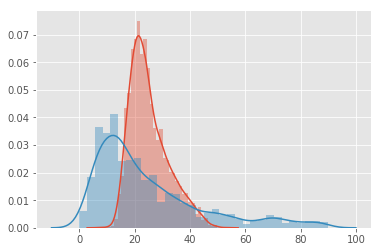

In [81]:
y_pred = mlp.predict(X_test)
sns.distplot(y_pred)
sns.distplot(y_test)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
kneigh = KNeighborsRegressor(n_neighbors=10)
cross_validation(kneigh, X_feat_train, y_feat_train).mean()

# Clustering

In [ ]:
# find best number of clusters
k_range = range(1,15)
df_k_loss = pd.Series(index=k_range)
for k in k_range:
    kmeans_k = KMeans().fit(X_norm)
    df_k_loss[k] = kmeans_k.inertia_

In [ ]:
df_k_loss.plot()

In [ ]:
kmeans = KMeans(5)
kmeans.fit(X_norm)

In [ ]:
plt.figure(figsize=(5,20))
sns.heatmap(kmeans.cluster_centers_.T, yticklabels=df_pred.drop(pred_name,1).columns, cmap='Blues')

In [ ]:
df_kmeans = df_pred.copy()
df_kmeans['kmeans'] = kmeans.labels_
df_kmeans.groupby('kmeans')['days_until_next_comp'].describe()

In [ ]:
rmse(df_kmeans.days_until_next_comp, df_kmeans.groupby('kmeans')['days_until_next_comp'].transform('mean'))

# PCA

In [ ]:
pca = PCA(2).fit(X_norm)
df_pca = pca.transform(X_norm)
df_pca = pd.DataFrame(df_pca)

In [ ]:
df_pca['cluster'] = kmeans.labels_
df_pca['weeks_until_next_comp'] = df_pred['days_until_next_comp'] // 7

In [ ]:
plt.figure(figsize=(10,5))
sns.scatterplot(df_pca[0], df_pca[1], hue=df_pca['cluster'], legend='full', palette='Dark2')

In [ ]:
pca.explained_variance_ratio_

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(abs(pca.components_).T, yticklabels=df_train_X.columns, cmap='Blues')

In [ ]:
df_train['kmeans'] = kmeans.labels_
df_train['kmeans_median'] = df_train.groupby('kmeans').days_until_next_comp.transform('median')